In [0]:
import pandas
import numpy
import math
import matplotlib.pyplot as plt
import seaborn
import os

  
**Предварительно файл с датасетом был обработан.** Модификация заголовков: для того, чтобы различать столбцы с одинаковыми заголовками, заголовки были переименованы; лишняя информация в заголовках была удалена. Строковые значения числовых параметров были удалены. Ячейки с текстом и '-' заменены пустыми.


In [36]:
dataset = pd.read_csv('dataset.csv')
dataset

,Номер,Дата,Глубина манометра,Dшт,Руст_ср,Рзаб_ср,Pлин_ср,Руст_кон,Рзаб_кон,Рлин_кон,Туст,Тна шлейфе,Тзаб,Tлин,Дебит газа станд,Дебит ст. конд.,Дебит воды станд,Дебит смеси,Дебит газа,Дебит кон нестабильный,Дебит воды лин,Нэф,Рпл. Тек (послед точка на КВД),Рпл. Тек (Расчет по КВД),Рпл. Тек (Карноухов),Pсб атм,Pсб бар,Ro_g,Ro_c,Ro_w,Удельная плотность газа,G_total,КГФ
0,804,05/06/08,3576.3,7.94,249.6,370.10,101.80,249.0,359.6,101.80,53.0,31.7,103.20,32.50,214.70,83.60,0.40,231.25,1610.37,131.3,0.4,56.80,45.25,56.5,NaN,93.6,92.38,0.806,801.0,1000.0,0.6694,2.78,311.91
1,804,06/06/08,3576.3,9.53,233.5,364.60,101.30,231.0,338.1,102.40,58.8,37.6,103.00,38.60,290.59,104.70,1.40,309.00,2310.23,158.5,1.4,56.80,45.25,56.5,NaN,92.9,91.69,0.806,801.0,1000.0,0.6694,3.70,288.60
2,804,07/06/08,3576.3,11.11,213.4,357.10,101.60,211.0,314.8,100.60,63.6,42.8,102.60,43.40,368.04,114.30,1.90,388.11,3039.49,172.3,1.9,56.80,45.25,56.5,NaN,91.4,90.20,0.806,801.0,1000.0,0.6694,4.52,248.79
3,804,08/06/08,3576.3,12.70,191.6,347.40,98.40,187.0,291.5,99.00,64.7,46.2,102.00,46.10,434.66,121.30,3.30,455.21,3824.08,181.5,3.3,56.80,45.25,56.5,NaN,89.2,88.03,0.806,801.0,1000.0,0.6694,5.22,223.56
4,804,09/06/08,3576.3,14.29,171.9,337.70,99.20,169.0,270.3,99.50,64.0,49.4,104.40,49.90,483.28,129.80,4.60,504.59,4299.10,190.6,4.7,56.80,45.25,56.5,NaN,89.7,88.53,0.806,801.0,1000.0,0.6694,5.77,215.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,22505,23/09/09,3678.0,12.70,182.2,271.59,93.26,179.0,258.6,92.70,55.6,41.8,104.91,41.83,394.60,85.10,1.50,408.97,3728.00,128.3,1.5,46.74,36.96,60.9,60.8,89.7,88.53,NaN,NaN,NaN,NaN,NaN,NaN
181,22505,27/09/09,3678.0,14.29,157.0,249.08,96.47,153.0,233.5,100.06,56.7,47.6,104.50,47.72,455.60,89.40,1.70,471.01,4302.00,135.9,1.7,46.74,36.96,60.9,60.8,87.3,86.16,NaN,NaN,NaN,NaN,NaN,NaN
182,22505,09/04/10,3679.5,7.94,211.9,289.39,91.13,208.0,289.6,91.30,47.0,24.4,104.90,24.84,188.43,61.47,1.12,200.87,1550.00,92.4,1.1,46.74,38.65,64.1,61.3,88.2,87.05,NaN,NaN,NaN,NaN,NaN,NaN
183,22505,14/04/10,3679.5,9.53,204.0,282.87,91.17,201.0,275.3,91.62,48.9,26.7,104.88,31.58,261.04,72.91,4.75,273.71,2265.00,108.9,4.8,46.74,38.65,64.1,61.3,88.5,87.34,NaN,NaN,NaN,NaN,NaN,NaN


**Пустые классы удаляются**

In [37]:
dataset = dataset[dataset['G_total'].notna() | dataset['КГФ'].notna()].reset_index(drop=True)
dataset

,Номер,Дата,Глубина манометра,Dшт,Руст_ср,Рзаб_ср,Pлин_ср,Руст_кон,Рзаб_кон,Рлин_кон,Туст,Тна шлейфе,Тзаб,Tлин,Дебит газа станд,Дебит ст. конд.,Дебит воды станд,Дебит смеси,Дебит газа,Дебит кон нестабильный,Дебит воды лин,Нэф,Рпл. Тек (послед точка на КВД),Рпл. Тек (Расчет по КВД),Рпл. Тек (Карноухов),Pсб атм,Pсб бар,Ro_g,Ro_c,Ro_w,Удельная плотность газа,G_total,КГФ
0,804,05/06/08,3576.3,7.94,249.60,370.1,101.80,249.0,359.6,101.80,53.0,31.7,103.20,32.50,214.70,83.6,0.40,231.25,1610.37,131.3,0.4,56.80,45.25,56.5,NaN,93.6,92.38,0.806,801.0,1000.0,0.6694,2.78,311.91
1,804,06/06/08,3576.3,9.53,233.50,364.6,101.30,231.0,338.1,102.40,58.8,37.6,103.00,38.60,290.59,104.7,1.40,309.00,2310.23,158.5,1.4,56.80,45.25,56.5,NaN,92.9,91.69,0.806,801.0,1000.0,0.6694,3.70,288.60
2,804,07/06/08,3576.3,11.11,213.40,357.1,101.60,211.0,314.8,100.60,63.6,42.8,102.60,43.40,368.04,114.3,1.90,388.11,3039.49,172.3,1.9,56.80,45.25,56.5,NaN,91.4,90.20,0.806,801.0,1000.0,0.6694,4.52,248.79
3,804,08/06/08,3576.3,12.70,191.60,347.4,98.40,187.0,291.5,99.00,64.7,46.2,102.00,46.10,434.66,121.3,3.30,455.21,3824.08,181.5,3.3,56.80,45.25,56.5,NaN,89.2,88.03,0.806,801.0,1000.0,0.6694,5.22,223.56
4,804,09/06/08,3576.3,14.29,171.90,337.7,99.20,169.0,270.3,99.50,64.0,49.4,104.40,49.90,483.28,129.8,4.60,504.59,4299.10,190.6,4.7,56.80,45.25,56.5,NaN,89.7,88.53,0.806,801.0,1000.0,0.6694,5.77,215.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,22503,28/01/09,3284.0,12.70,215.00,307.8,98.60,215.0,308.1,97.20,65.0,45.8,104.78,46.30,479.09,93.5,4.70,495.63,4165.00,156.8,4.8,44.50,35.28,40.5,41.6,94.4,93.17,NaN,782.0,NaN,0.6600,NaN,153.00
89,22503,01/02/09,3284.0,14.29,198.00,293.6,98.50,197.0,293.9,98.40,66.9,49.8,104.63,50.50,568.50,106.6,6.40,587.36,5113.00,174.3,6.5,44.50,35.28,40.5,41.6,94.0,92.77,NaN,782.0,NaN,0.6600,NaN,147.00
90,22503,16/08/10,3288.6,7.94,231.23,309.1,92.60,230.0,307.1,92.70,51.0,NaN,104.40,28.10,215.80,50.5,0.45,224.86,1759.00,84.7,0.4,48.37,33.21,NaN,NaN,89.9,88.72,NaN,779.6,NaN,0.6700,NaN,182.00
91,22503,20/08/10,3288.6,11.11,217.20,293.9,93.10,215.0,293.9,93.30,60.0,NaN,104.60,41.30,387.68,72.0,1.50,403.75,3454.00,123.0,1.6,48.37,33.21,NaN,NaN,90.8,89.61,NaN,779.6,NaN,0.6700,NaN,145.00


**Классы**

In [38]:
classes = dataset[['G_total', 'КГФ']].drop_duplicates().replace(numpy.nan, '', regex=True)
classes = [tuple(x) for x in classes.to_numpy()]
print(f'Классов: {len(classes)}')
classes

Классов: 72


[(2.78, 311.91),
 (3.7, 288.6),
 (4.52, 248.79),
 (5.22, 223.56),
 (5.77, 215.15),
 (3.08, 241.13),
 ('', 188.0),
 ('', 178.0),
 ('', 169.0),
 ('', 162.0),
 ('', 230.0),
 ('', 201.0),
 ('', 172.0),
 ('', 157.0),
 ('', 141.0),
 (4.23, 385.42),
 (4.71, 295.5),
 (5.73, 255.68),
 (5.78, 233.96),
 (5.76, 223.11),
 (5.25, 199.63),
 (4.25, 245.68),
 (3.72, 294.59),
 (5.17, 282.24),
 (8.4, 280.56),
 (9.64, 292.24),
 (10.93, 284.08),
 (9.33, 289.18),
 (6.42, 287.52),
 (4.59, 254.84),
 (5.83, 243.23),
 (7.28, 219.04),
 ('', 270.0),
 ('', 251.0),
 ('', 236.0),
 ('', 217.0),
 ('', 200.0),
 ('', 180.0),
 ('', 160.0),
 ('', 156.0),
 ('', 153.0),
 ('', 152.0),
 ('', 138.0),
 ('', 131.0),
 ('', 212.0),
 ('', 194.0),
 ('', 187.0),
 ('', 198.0),
 ('', 174.0),
 ('', 171.0),
 ('', 165.0),
 ('', 140.0),
 ('', 154.0),
 ('', 139.0),
 ('', 132.0),
 ('', 241.0),
 ('', 216.0),
 ('', 191.0),
 ('', 177.0),
 ('', 164.0),
 ('', 219.0),
 ('', 218.0),
 ('', 161.0),
 ('', 224.0),
 ('', 199.0),
 ('', 192.0),
 ('', 222.

**Атрибуты**

In [39]:
attributes = tuple(dataset.columns[:-2].to_numpy())
print(f'Аттрибутов {len(attributes)}')
attributes

Аттрибутов 31


('Номер',
 'Дата',
 'Глубина манометра',
 'Dшт',
 'Руст_ср',
 'Рзаб_ср',
 'Pлин_ср',
 'Руст_кон',
 'Рзаб_кон',
 'Рлин_кон',
 'Туст',
 'Тна шлейфе',
 'Тзаб',
 'Tлин',
 'Дебит газа станд',
 'Дебит ст. конд.',
 'Дебит воды станд',
 'Дебит смеси',
 'Дебит газа',
 'Дебит кон нестабильный',
 'Дебит воды лин',
 'Нэф',
 'Рпл. Тек (послед точка на КВД)',
 'Рпл. Тек (Расчет по КВД)',
 'Рпл. Тек (Карноухов)',
 'Pсб атм',
 'Pсб бар',
 'Ro_g',
 'Ro_c',
 'Ro_w',
 'Удельная плотность газа ')

**gain ratio**

In [0]:
def get_gain_ratios(examples):
    gain_ratios = {}
    for attribute in attributes:
        gain_ratios[attribute] = get_gain_ratio(attribute, examples)
    return pandas.Series(gain_ratios)


def get_gain_ratio(attribute, examples):
    split_info = calculate_split_info(attribute, examples)
    gain = calculate_entropy(examples) - calculate_attribute_entropy(attribute, examples)
    if split_info == 0:
        return 0;
    return gain / split_info;


def calculate_attribute_entropy(attribute, examples):
    attribute_entropy = 0.0
    all_examples_amount = len(examples.index)
    attribute_values = examples[attribute].dropna().drop_duplicates().to_numpy()
    for attribute_value in attribute_values:
        attribute_value_examples = examples[examples[attribute] == attribute_value]
        entropy = calculate_entropy(attribute_value_examples)
        attribute_examples_amount = len(attribute_value_examples.index)
        attribute_entropy += attribute_examples_amount / all_examples_amount * entropy
    return attribute_entropy


def calculate_entropy(examples):
    entropy = 0.0
    result_class_amount_dict = get_result_class_amount_dict(examples)
    examples_amount = len(examples.index)
    for _, result_class_amount in result_class_amount_dict.items():
        if result_class_amount == 0:
            continue;
        probability = result_class_amount / examples_amount
        entropy -= probability * math.log2(probability)
    return entropy;


def get_result_class_amount_dict(examples):
    result_class_amount_dict = dict.fromkeys(classes, 0)
    result_classes_array = examples[['G_total', 'КГФ']].replace(numpy.nan, '', regex=True).to_numpy()
    for result_class in result_classes_array:
        result_class_amount_dict[tuple(result_class)] += 1

    return result_class_amount_dict


def calculate_split_info(attribute, examples):
    split_info = 0.0
    attribute_values = examples[attribute].dropna().drop_duplicates().to_numpy()
    all_examples_amount = len(examples.index)
    for attribute_value in attribute_values:
        attribute_value_examples = examples[examples[attribute] == attribute_value]
        attribute_examples_amount = len(attribute_value_examples.index)
        split_info -= attribute_examples_amount / all_examples_amount * math.log2(attribute_examples_amount/all_examples_amount)
    return split_info


**Диаграмма важности признаков**

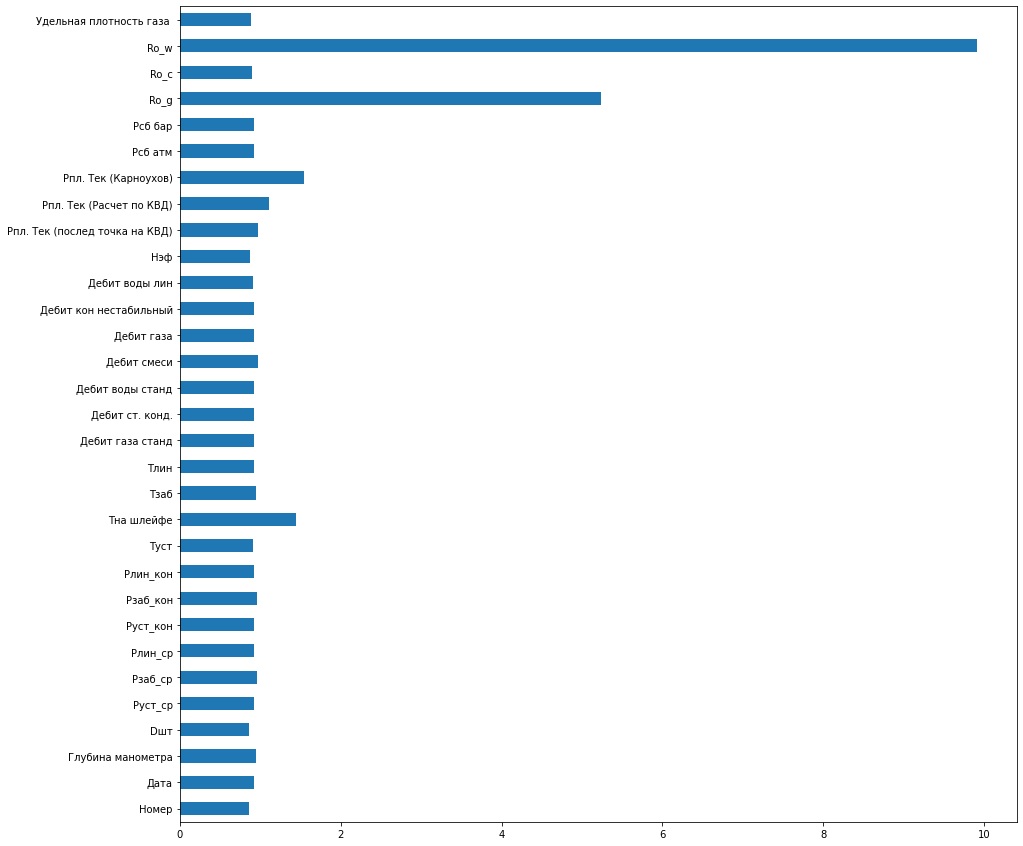

In [41]:
plt.rcParams['figure.figsize'] = [15, 15]
gain_ratios = get_gain_ratios(dataset)
gain_ratios.plot.barh(figsize=(15,15));

**Гистограммы распределений значений**


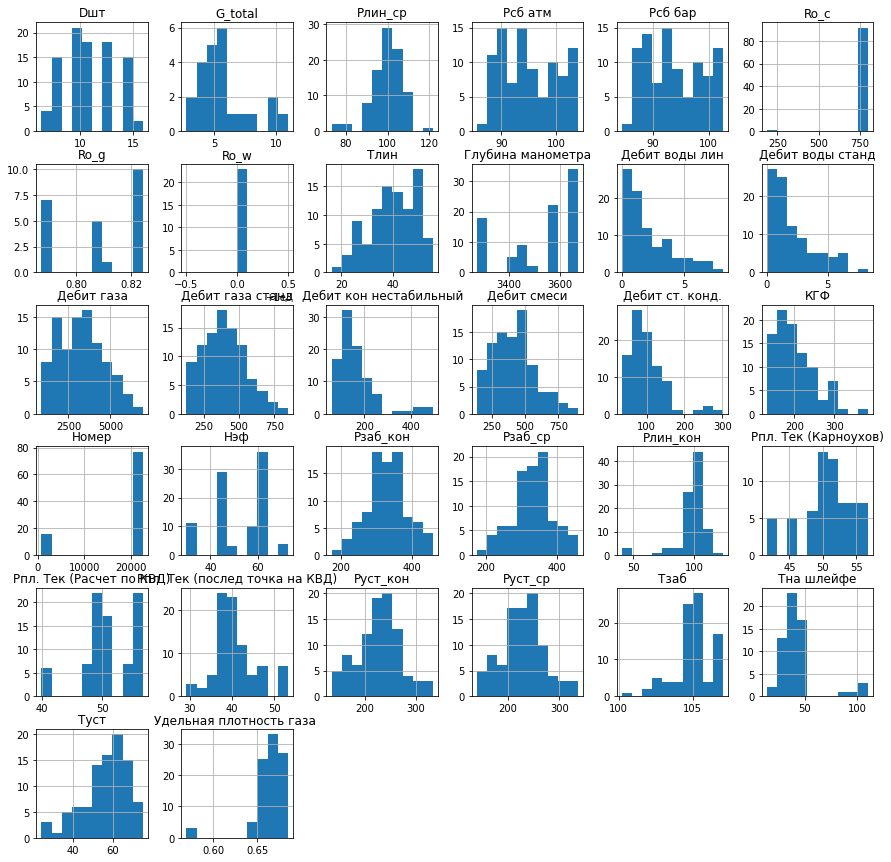

In [42]:
dataset.hist(figsize=(15,15));

**Корреляции - тепловая карта признаков**

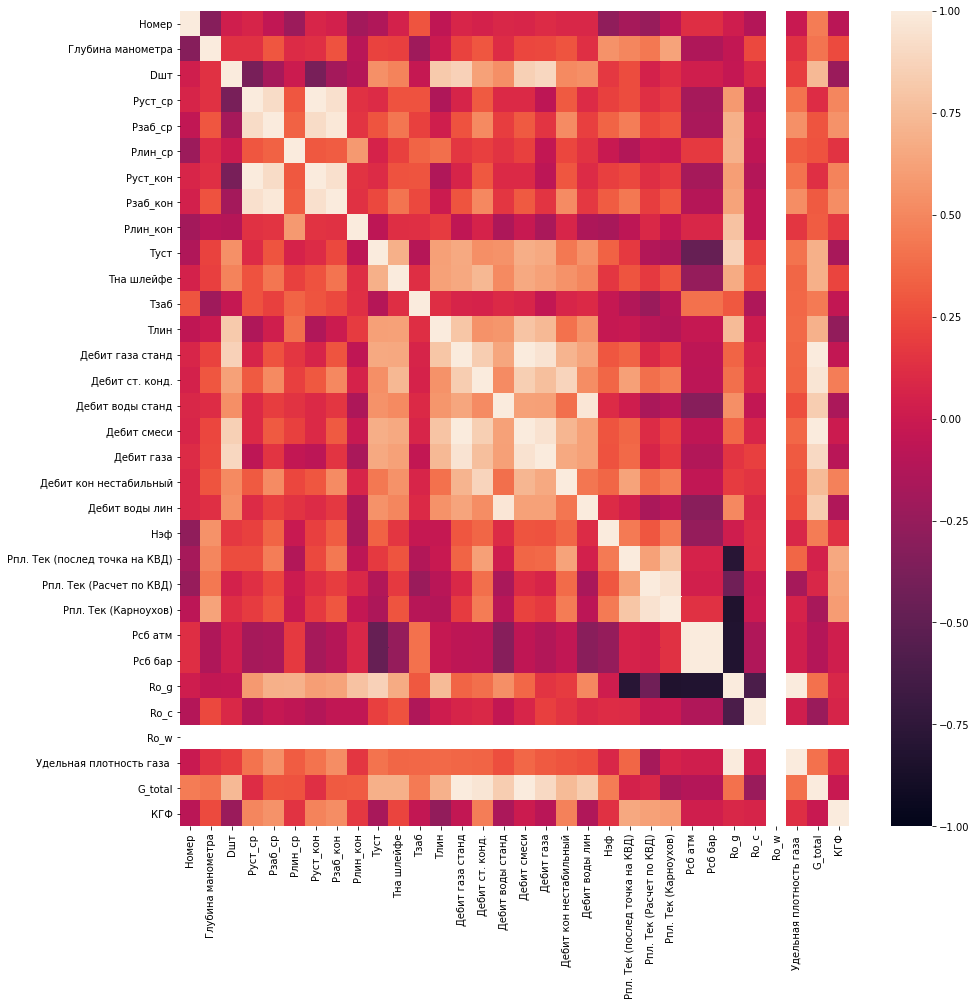

In [43]:
seaborn.heatmap(dataset.corr(), vmin=-1, vmax=1, xticklabels = True, yticklabels = True);

**Диаграмма пропущенных значений**

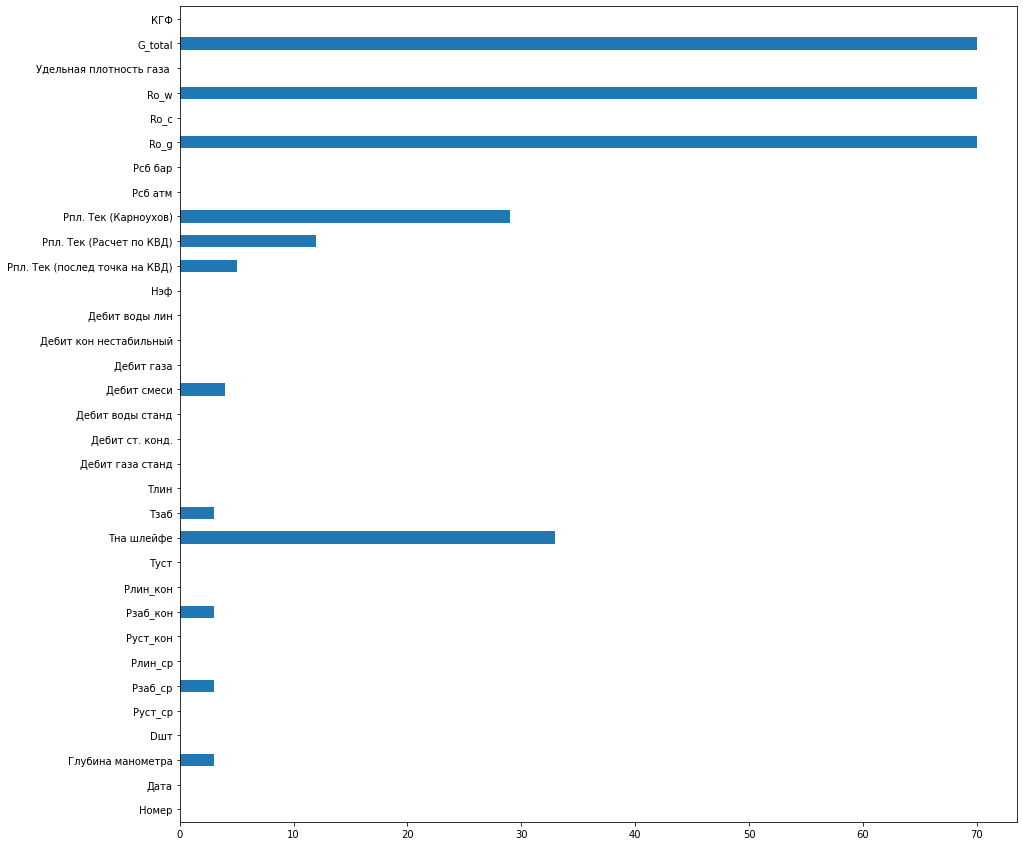

In [44]:
missing_values = dataset.isna().sum()
missing_values.plot.barh(figsize=(15,15));

**Диаграмма уникальных значений**

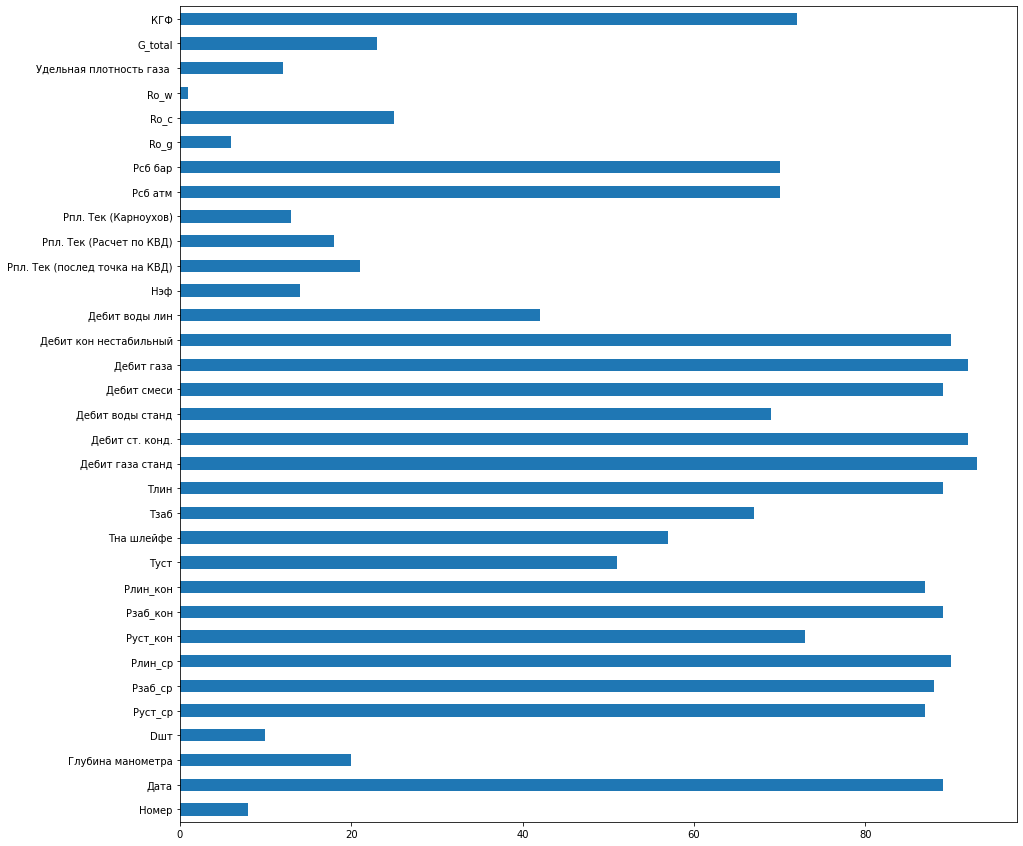

In [45]:
unique_values = dataset.nunique()
unique_values.plot.barh(figsize=(15,15));

**Вывод:**
Выбор параметров для второй лабораторной

Убираются параметры: 

*   Для параметра **Номер** мало уникальных значений.
*  Параметр **Дата** убирается (не является необходимым параметром при обучении).
* Параметр **Dшт** убираем так как коррелирует с параметром Дебит газа, немного уникальных значений. 
* Параметр **Руст_ср** коррелирует с параметром Руст_кон и с целевыми параметрами.
* Параметр **Рзаб_ср** коррелирует с параметром Рзаб_кон и с целевыми параметрами.
* Параметр **Тна Шлейфе**, так как много пропущенных значений.
* Параметр **Дебит смеси** коррелирует с параметром Дебит газа станд и меньше уникальных значений относительно параметра Дебит газа станд.
* Параметр **Дебит газа** коррелирует с параметром Дебит газа станд и меньше уникальных значений относительно параметра Дебит газа станд.
* Параметр **Дебит воды лин** коррелирует с параметром Дебит воды станд, меньше уникальных значений относительно параметра Дебит воды станд.
* Параметр **Нэф** небольшой gr, мало уникальных значений.
* Параметр **Рпл. Тек (Карноухов)**  много пропущенных значений, мало уникальных.
* Параметр **Удельная плотность газа**  мало уникальных значений, небольшой gr.
* Параметр **Ro_g**  много пропущенных значений, мало уникальных.
* Параметр **Ro_w **  много пропущенных значений, мало уникальных.
* Параметр **Pсб бар** корелляция со всеми остальными признаками такая же, как у параметра Рсб атм.

Выбранные параметры:
* Глубина манометра, 
* Руст_кон, 
* Рзаб_кон, 
* Pлин_кон, 
* Рпл. Тек (послед точка на КВД),
* Рпл. Тек (Расчет по КВД), 
* Pсб атм, 
* Ro_c, 
* Туст,
* Тзаб, 
* Tлин, 
* Дебит газа станд, 
* Дебит ст. конд., 
* Дебит воды станд, 
* Дебит кон нестабильный






